In [1]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
# plt.style.use('ggplot')
# % matplotlib inline

In [3]:
df = pd.read_csv('CrisisLexT26/2013_LA_airport_shootings/2013_LA_airport_shootings-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          682
Related - but not informative    230
Not related                       87
Not applicable                    33
Name: Informativeness, dtype: int64

In [4]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          646
Related - but not informative    226
Not related                       87
Name: Informativeness, dtype: int64

In [5]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,396205490209693696,KING D ROYALTY http://t.co/eXjB4V0rbx … #LA #L...,Not labeled,Not labeled,Not related,Not related or not informative
1,396313082466541568,Something's happening @ #LAX rt now!! Re-tweet.,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative
2,396313543865552896,#KourtneyKardashian is seen arriving at #LAX a...,Not labeled,Not labeled,Not related,Not related or not informative
3,396314030383443968,"What the hell is going on at LAX, and why does...",Outsiders,Affected individuals,Related - but not informative,Not related or not informative
4,396314902794498048,RT @efink: Gunfire on the tarmac. RT @CBSLA #B...,Media,Affected individuals,Related and informative,Related and informative


In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import preprocessor as p

emoji_re = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emojis = [regexp_tokenize(t, emoji_re) for t in df.TweetText]
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i] if t not in en_stop ]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,396205490209693696,KING D ROYALTY http://t.co/eXjB4V0rbx … #LA #L...,Not labeled,Not labeled,Not related,Not related or not informative,king royalty … #la #lax #oakland #sf #bayarea ...
1,396313082466541568,Something's happening @ #LAX rt now!! Re-tweet.,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,something's happening @ #lax rt ! ! re-tweet .
2,396313543865552896,#KourtneyKardashian is seen arriving at #LAX a...,Not labeled,Not labeled,Not related,Not related or not informative,#kourtneykardashian seen arriving #lax airport...
3,396314030383443968,"What the hell is going on at LAX, and why does...",Outsiders,Affected individuals,Related - but not informative,Not related or not informative,"hell going lax , something bad always happen a..."
4,396314902794498048,RT @efink: Gunfire on the tarmac. RT @CBSLA #B...,Media,Affected individuals,Related and informative,Related and informative,rt @efink : gunfire tarmac . rt @cbsla #breaki...


In [8]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [31]:
mnb_count_pp = MultinomialNB(0.005)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

from sklearn.cross_validation import cross_val_score, KFold 
from scipy.stats import sem 

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)  
    scores = cross_val_score(clf, X, y, cv=cv) 
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.94444444 0.79166667 0.83333333 0.77777778 0.86111111 0.875
 0.79166667 0.84722222 0.875      0.83098592]
Mean score: 0.843 (+/-0.016)
Accuracy for training: 0.97635605007
Accuracy for testing: 0.870833333333


In [33]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.85      0.75      0.79        80
       Related and informative       0.88      0.93      0.91       160

                   avg / total       0.87      0.87      0.87       240

Confusion Matrix:
[[ 60  20]
 [ 11 149]]


In [35]:
X_count_pp_test.shape

(240, 2088)

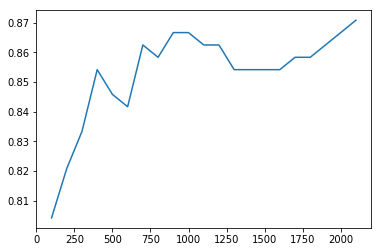

[0.8041666666666667, 0.8208333333333333, 0.8333333333333334, 0.8541666666666666, 0.8458333333333333, 0.8416666666666667, 0.8625, 0.8583333333333333, 0.8666666666666667, 0.8666666666666667, 0.8625, 0.8625, 0.8541666666666666, 0.8541666666666666, 0.8541666666666666, 0.8541666666666666, 0.8583333333333333, 0.8583333333333333, 0.8625, 0.8666666666666667, 0.8708333333333333]


In [40]:
k = range(100,2200,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(0.005)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### cancel stop words

In [41]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,396205490209693696,KING D ROYALTY http://t.co/eXjB4V0rbx … #LA #L...,Not labeled,Not labeled,Not related,Not related or not informative,king d royalty … #la #lax #oakland #sf #bayare...
1,396313082466541568,Something's happening @ #LAX rt now!! Re-tweet.,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,something's happening @ #lax rt now ! ! re-twe...
2,396313543865552896,#KourtneyKardashian is seen arriving at #LAX a...,Not labeled,Not labeled,Not related,Not related or not informative,#kourtneykardashian is seen arriving at #lax a...
3,396314030383443968,"What the hell is going on at LAX, and why does...",Outsiders,Affected individuals,Related - but not informative,Not related or not informative,"what the hell is going on at lax , and why doe..."
4,396314902794498048,RT @efink: Gunfire on the tarmac. RT @CBSLA #B...,Media,Affected individuals,Related and informative,Related and informative,rt @efink : gunfire on the tarmac . rt @cbsla ...


In [42]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [64]:
mnb_count_pp = MultinomialNB(0.05)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.93055556 0.83333333 0.83333333 0.79166667 0.81944444 0.93055556
 0.77777778 0.90277778 0.90277778 0.8028169 ]
Mean score: 0.853 (+/-0.019)
Accuracy for training: 0.97635605007
Accuracy for testing: 0.883333333333


In [66]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.83      0.81      0.82        80
       Related and informative       0.91      0.92      0.91       160

                   avg / total       0.88      0.88      0.88       240

Confusion Matrix:
[[ 65  15]
 [ 13 147]]


In [67]:
X_count_pp_test.shape

(240, 2187)

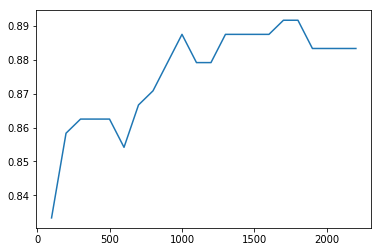

[0.8333333333333334, 0.8583333333333333, 0.8625, 0.8625, 0.8625, 0.8541666666666666, 0.8666666666666667, 0.8708333333333333, 0.8791666666666667, 0.8875, 0.8791666666666667, 0.8791666666666667, 0.8875, 0.8875, 0.8875, 0.8875, 0.8916666666666667, 0.8916666666666667, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333]


In [71]:
k = range(100,2300,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(0.05)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

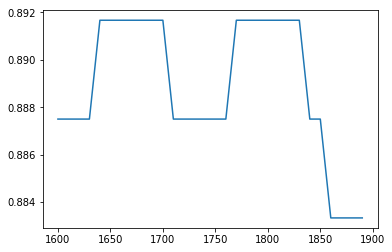

[0.8875, 0.8875, 0.8875, 0.8875, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8875, 0.8875, 0.8875, 0.8875, 0.8875, 0.8875, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8916666666666667, 0.8875, 0.8875, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333]


In [72]:
k = range(1600,1900,10)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(0.05)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score